## DANN(Doain Adversial Neural Network)

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.datasets import make_moons
from matplotlib import pyplot
from pandas import DataFrame

### Generate Source Samples

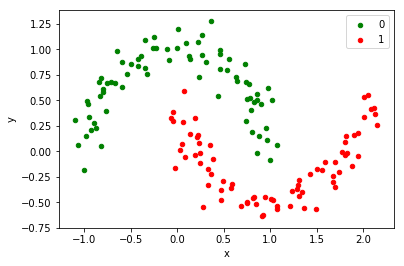

In [13]:
X, y = make_moons(n_samples=150, noise=0.1)
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {1:'red', 0:'green'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y',label=key, color=colors[key])
pyplot.show()

### Generate Target Samples

/home/seokinj/.local/lib/python3.5/site-packages/ipykernel_launcher.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # Remove the CWD from sys.path while we load stuff.


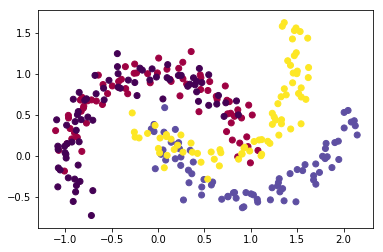

In [14]:
#df2 = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
# rotate degree of 35
ang = np.radians(35)
xsin = np.multiply(np.sin(ang), df.x)
xcos = np.multiply(np.cos(ang), df.x)
ysin = np.multiply(np.sin(ang), df.y)
ycos = np.multiply(np.cos(ang), df.y)
#df2.x = xcos - ysin
#df2.y = xsin + ycos
X2 = np.concatenate(((xcos-ysin).reshape(1,150), (xsin+ycos).reshape(1,150)), axis=0).T
df2 = DataFrame(dict(x=X2[:,0], y=X2[:,1], label=y))

colors2 = {1:'blue', 0:'yellow'}
#fig2, ax2 = pyplot.subplots()
#grouped2 = df2.groupby('label')
#for key, group in grouped2:
    # remove labels
#    group.plot(ax=ax2, kind='scatter', x='x', y='y', label=key, color=colors2[key])
#pyplot.show()
pyplot.scatter(X[:,0], X[:,1], c=y, cmap=pyplot.cm.Spectral)
pyplot.scatter(X2[:,0], X2[:,1], c=y)
pyplot.show()


### NN(Neural Net) - hidden layer(15)

In [15]:
input_sz = 2
hidden_sz = 15
num_classes = 2
num_epochs = 1
batch_sz = 50
learning_rate = 0.05
hyper = 6

class Net(nn.Module):
    def __init__(self, input_sz, hidden_sz, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_sz, hidden_sz)
        self.sig = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_sz, num_classes)
        self.soft = nn.Softmax()

    def forward(self, x):
        out = self.fc1(x)
        in_da = self.sig(out) # domain adaptation input
        out = self.fc2(in_da)
        out = self.soft(out)
        return in_da, out

### DANN(Domain Adversarial NN) - hidden layer(15)

In [16]:
class DANN(nn.Module):
    def __init__(self, hidden_sz, num_classes):
        super(DANN, self).__init__()
        self.fc3 = nn.Linear(hidden_sz, num_classes)
        self.sig = nn.Sigmoid()
        
    def forward(self, x): # x : Gf(x)
        out = self.fc3(x)
        out = self.sig(out) # Gd(Gf) 
        return out 

### Train the Model - without DA

In [22]:
net = Net(input_sz, hidden_sz, num_classes)
dann = DANN(hidden_sz, num_classes)

# Loss 
criterion = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    for i in range(0, len(df)):
    #for i, d in df.iterrows():
        #new_d = torch.FloatTensor(d.as_matrix(['x','y']))
        #new_l = torch.LongTensor(np.array(d['label'], dtype=np.float64).reshape(1,))
        new_d = torch.FloatTensor(X[i])
        new_l = torch.LongTensor(np.array(y[i], dtype=np.int64).reshape(1,))
        
        data = Variable(new_d.view(-1,2))
        labels = Variable(new_l)
        
        in_da, outputs = net(data)
        loss = criterion(outputs, labels)
        loss.backward(retain_graph=True)

        # Domain adaptation regularizer (source)
        outputs2 = dann(in_da)
        loss2 = criterion(outputs2, Variable(torch.LongTensor(np.array(1).reshape(1,))))
        loss2.backward(retain_graph=True)      
        
        for name, param in dann.named_parameters():
            if name in 'fc3.weight':
                delta_u = -1 * hyper * param.grad.data
                u = param
            else:
                #print(name) #fc3.bias, 'd'
                delta_d = -1 * hyper * param.grad.data
        
        ####### type ########
        # tmp : Float Tensor#
        # u : Parametor     #
        # in_da : Variable  #
        #####################
        
        ####################### size ######################
        # d : [2]                                         #
        # delta_d : [2] = [1,2]                           #
        # u : [2,15]                                      #
        # in_data : [1,15]                                #
        # tmp : [1,2] @ [2,15] * [1,15] * [1,15] = [1,15] #
        # b : [15] = [15,1]                               #
        # delta_b : [15,1]                                #
        # w : [15,2]                                      #
        # data.data : [2,1]                               #
        # delta_w : [15,2]                                #
        ###################################################
        
        tmp = delta_d.view(1,2) @ u.data * in_da.data * (1-in_da.data)
        
        for name, param in net.named_parameters():
            if name in 'fc1.bias':
                delta_b = param.data.view(15, 1) + tmp.t()
            if name in 'fc1.weight':
                delta_w = param.data + tmp.t() @ data.data 
        
        # Domain adaptation regularizer (target)
        target_d = torch.FloatTensor(X2[i]).contiguous()
        target_data = Variable(target_d.view(-1,2))                
        in_da2, q = net(target_data)
        outputs3 = dann(in_da2)
        loss3 = criterion(outputs3, Variable(torch.LongTensor(np.array(0).reshape(1,))))
        loss3.backward()

        for name, param in dann.named_parameters():
            if name in 'fc3.weight':
                delta_u2 = delta_u + (-1 * hyper * param.grad.data)
            else:
                k = -1 * hyper * param.grad.data
                delta_d2 = delta_d + k

        tmp2 = k.view(1,2) @ u.data * in_da2.data * (1-in_da2.data) 

        delta_b = delta_b + tmp2.t()
        delta_w = delta_w + tmp2.t() @ target_data.data

        # Update NN parameters
        for name, param in net.named_parameters():
            if name in 'fc1.bias':
                param.data = param.data - learning_rate * delta_b.view(15)
            if name in 'fc1.weight':
                param.data = param.data - learning_rate * delta_w
            if name in 'fc2.bias':
                param.data = param.data - learning_rate * param.grad.data
            if name in 'fc2.weight':
                param. data = param.data - learning_rate * param.grad.data
        
        # Update DANN parameters
        for name, param in dann.named_parameters():
            if name in 'fc3.bias':
                param.data = param.data + learning_rate * delta_d2
                
            if name in 'fc3.weight':    
                param.data = param.data + learning_rate * delta_u2
        
        # zero the gradient buffer
        for param in net.parameters():
            param.grad.data.zero_()
        for param in dann.parameters():
            param.grad.data.zero_()
        

        if (i+1) % 50 == 0:
            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' % (epoch+1, num_epochs, i+1, len(df)//batch_sz, loss.data[0]-hyper*(loss2.data[0]+loss3.data[0])))
        

/home/seokinj/.local/lib/python3.5/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Variable containing:
 0.7810  0.2190
[torch.FloatTensor of size 1x2]

Variable containing:
 0
[torch.LongTensor of size 1]

Variable containing:
 0.7523  0.2477
[torch.FloatTensor of size 1x2]

Variable containing:
 0
[torch.LongTensor of size 1]

Variable containing:
 0.7461  0.2539
[torch.FloatTensor of size 1x2]

Variable containing:
 0
[torch.LongTensor of size 1]

Variable containing:
 0.7075  0.2925
[torch.FloatTensor of size 1x2]

Variable containing:
 0
[torch.LongTensor of size 1]

Variable containing:
 0.7133  0.2867
[torch.FloatTensor of size 1x2]

Variable containing:
 0
[torch.LongTensor of size 1]

Variable containing:
 0.6816  0.3184
[torch.FloatTensor of size 1x2]

Variable containing:
 0
[torch.LongTensor of size 1]

Variable containing:
 0.6859  0.3141
[torch.FloatTensor of size 1x2]

Variable containing:
 0
[torch.LongTensor of size 1]

Variable containing:
 0.6714  0.3286
[torch.FloatTensor of size 1x2]

Variable containing:
 0
[torch.LongTensor of size 1]

Variable


Variable containing:
 0.5463  0.4537
[torch.FloatTensor of size 1x2]

Variable containing:
 0
[torch.LongTensor of size 1]

Variable containing:
 0.5740  0.4260
[torch.FloatTensor of size 1x2]

Variable containing:
 0
[torch.LongTensor of size 1]

Variable containing:
 0.6003  0.3997
[torch.FloatTensor of size 1x2]

Variable containing:
 0
[torch.LongTensor of size 1]

Variable containing:
 0.6245  0.3755
[torch.FloatTensor of size 1x2]

Variable containing:
 0
[torch.LongTensor of size 1]

Variable containing:
 0.6469  0.3531
[torch.FloatTensor of size 1x2]

Variable containing:
 0
[torch.LongTensor of size 1]

Variable containing:
 0.6185  0.3815
[torch.FloatTensor of size 1x2]

Variable containing:
 0
[torch.LongTensor of size 1]

Variable containing:
 0.6411  0.3589
[torch.FloatTensor of size 1x2]

Variable containing:
 0
[torch.LongTensor of size 1]

Variable containing:
 0.6122  0.3878
[torch.FloatTensor of size 1x2]

Variable containing:
 0
[torch.LongTensor of size 1]

Variabl

### Test the model


 0.7037  0.2963
[torch.FloatTensor of size 1x2]


 0.7026  0.2974
[torch.FloatTensor of size 1x2]


 0.7028  0.2972
[torch.FloatTensor of size 1x2]


 0.7029  0.2971
[torch.FloatTensor of size 1x2]


 0.7037  0.2963
[torch.FloatTensor of size 1x2]


 0.7034  0.2966
[torch.FloatTensor of size 1x2]


 0.7033  0.2967
[torch.FloatTensor of size 1x2]


 0.7033  0.2967
[torch.FloatTensor of size 1x2]


 0.7027  0.2973
[torch.FloatTensor of size 1x2]


 0.7039  0.2961
[torch.FloatTensor of size 1x2]


 0.7033  0.2967
[torch.FloatTensor of size 1x2]


 0.7030  0.2970
[torch.FloatTensor of size 1x2]


 0.7040  0.2960
[torch.FloatTensor of size 1x2]


 0.7027  0.2973
[torch.FloatTensor of size 1x2]


 0.7028  0.2972
[torch.FloatTensor of size 1x2]


 0.7029  0.2971
[torch.FloatTensor of size 1x2]


 0.7028  0.2972
[torch.FloatTensor of size 1x2]


 0.7027  0.2973
[torch.FloatTensor of size 1x2]


 0.7034  0.2966
[torch.FloatTensor of size 1x2]


 0.7034  0.2966
[torch.FloatTensor of size 1x2]



/home/seokinj/.local/lib/python3.5/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/seokinj/.local/lib/python3.5/site-packages/ipykernel_launcher.py:19: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


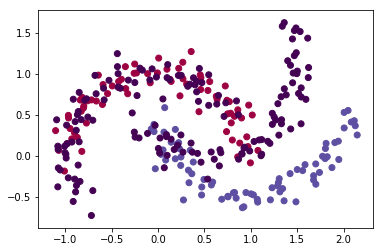

In [20]:
x_min, x_max = X[:,0].min()-.5, X[:,0].max()+.5
y_min, y_max = X[:,1].min()-.5, X[:,1].max()+.5
h = .01
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = np.zeros(1,)
'''
for i in np.c_[xx.ravel(), yy.ravel()]:
    test_dat = Variable(torch.FloatTensor(i).view(-1,2))
    outputs = net(test_dat)[1]
    Z = np.append(Z, torch.max(outputs.data, 1)[1])
'''
for i in range(0, len(df)):
    test_dat = Variable(torch.FloatTensor(X2[i]).contiguous().view(-1,2))
    outputs = net(test_dat)[1]
    print(outputs.data)
    Z = np.append(Z, torch.max(outputs.data, 1)[1])

Z = np.delete(Z, Z[0])
#Z = Z.reshape(1,-1).reshape(xx.shape)#reshape(xx.shape)
print(y)
print(Z)

#pyplot.contourf(xx, yy, Z, cmap=pyplot.cm.Spectral, levels=[0, 0.5])
#pyplot.pcolormesh(xx, yy, Z, cmap=pyplot.cm.Spectral)
pyplot.scatter(X[:,0], X[:,1], c=y, cmap=pyplot.cm.Spectral)
#pyplot.scatter(xx, yy, c= , cmap=pyplot.cm.Spectral)
pyplot.scatter(X2[:,0], X2[:,1], c=Z)
pyplot.show()